In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of 2013 for the case study

In [44]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')

data_subset = data.loc['2013-01-01':'2014-01-01']

In [45]:
data_subset.head()

,item_id,sell_price,wday,snap_CA,snap_TX,snap_WI,sales,special_events,sin_wday,cos_wday
date,,,,,,,,,,
2013-01-01,FOODS_1_004,1.78,4.0,1.0,1.0,0.0,69.0,1.0,-4.338837e-01,-0.900969
2013-01-02,FOODS_1_004,1.78,5.0,1.0,0.0,1.0,81.0,0.0,-9.749279e-01,-0.222521
2013-01-03,FOODS_1_004,1.78,6.0,1.0,1.0,1.0,110.0,0.0,-7.818315e-01,0.623490
2013-01-04,FOODS_1_004,1.78,7.0,1.0,0.0,0.0,84.0,0.0,-2.449294e-16,1.000000
2013-01-05,FOODS_1_004,1.78,1.0,1.0,1.0,1.0,98.0,0.0,7.818315e-01,0.623490


Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [46]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-3:-2]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [47]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item.reset_index()

In [48]:
def estimateSignificantLags(ts, nlags = 100, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   5   6   7   8  13  14  99 100]


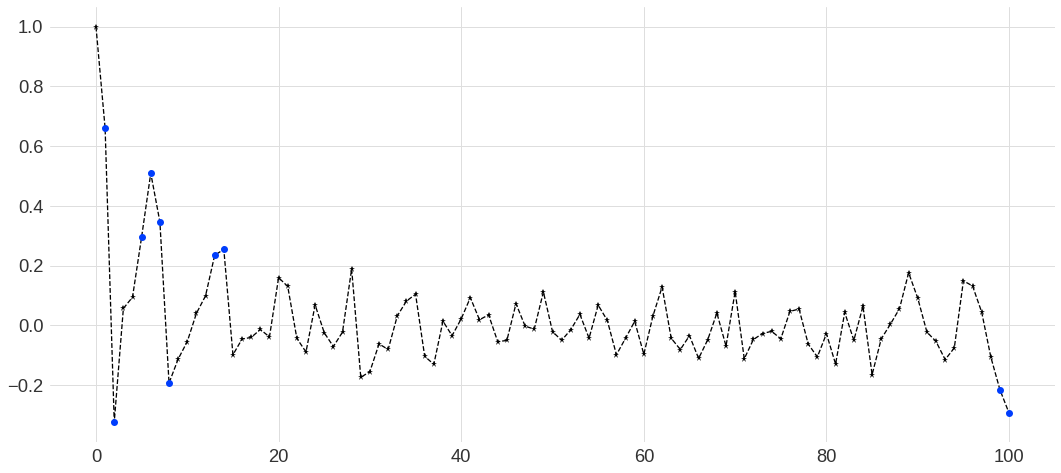

In [49]:
lags = estimateSignificantLags(get_input_item(item_id='FOODS_3_252').sales, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

In [ ]:
get_input_item('FOODS_3_252')

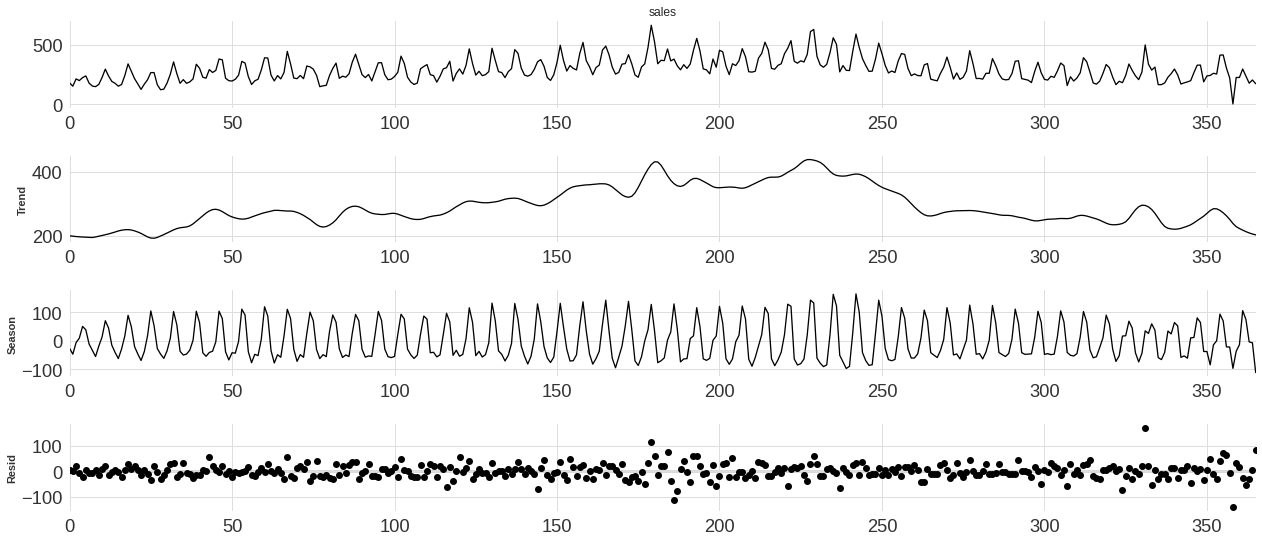

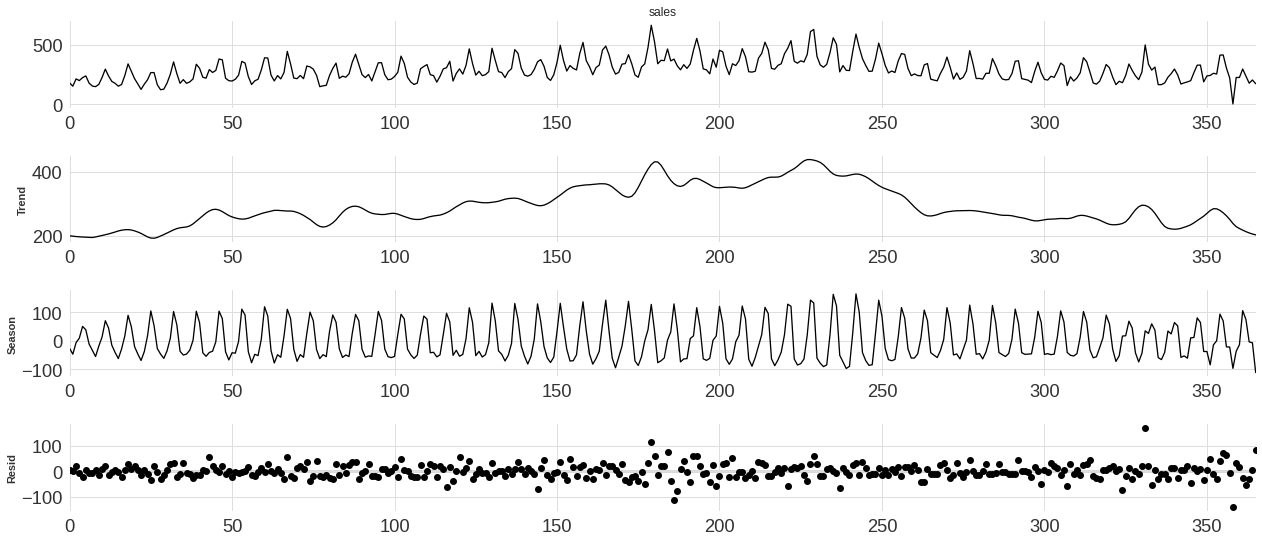

In [51]:
from statsmodels.tsa.seasonal import STL
res = STL(get_input_item(item_id='FOODS_3_252').sales, period=7).fit()
res.plot()

## Building prediction models

In [52]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.5, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates=None,
                             past_covariates=None,
                             model_display_name=None, 
                             past_covs = False,
                             future_covs = False):

    horizon = 1
    
    forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              past_covariates = past_covariates if past_covs else None,
                                              future_covariates = future_covariates if future_covs else None,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*2)]
    else:
        return res_df
    #return res_df

In [53]:
data.reset_index(inplace=True)

In [54]:
data.head()

,date,item_id,sell_price,wday,snap_CA,snap_TX,snap_WI,sales,special_events,sin_wday,cos_wday
0,2012-03-03,FOODS_1_004,1.78,1.0,1.0,1.0,1.0,0.0,0.0,0.781831,0.623490
1,2012-03-04,FOODS_1_004,1.78,2.0,1.0,0.0,0.0,0.0,0.0,0.974928,-0.222521
2,2012-03-05,FOODS_1_004,1.78,3.0,1.0,1.0,1.0,0.0,0.0,0.433884,-0.900969
3,2012-03-06,FOODS_1_004,1.78,4.0,1.0,1.0,1.0,0.0,0.0,-0.433884,-0.900969
4,2012-03-07,FOODS_1_004,1.78,5.0,1.0,1.0,0.0,1.0,0.0,-0.974928,-0.222521


In [55]:
 def create_forecast_for_item(itemid, lags = [-1,-2,-52],lags_future_covariates=[0,1]):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), value_cols=['sales'])

    
    val_cols = ['sin_wday','cos_wday','special_events','snap_CA','snap_TX','snap_WI']
    
    external_covs = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), 
                                       value_cols=val_cols)
    
    
    # We first set aside the first 50% as training series:
    input_train, _ = input_timeseries.split_before(0.50)

    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=lags)
    regr_model_lags.fit(input_train)

    regr_model_cov = RegressionModel(lags=lags,
                                     lags_past_covariates = lags,
                                     lags_future_covariates = lags_future_covariates)
    
    regr_model_cov.fit(input_train,
                       future_covariates = external_covs,
                       past_covariates = external_covs)

    """
    lgbm_model_cov = LightGBMModel(lags = lags,
                                   lags_past_covariates = lags,
                                   lags_future_covariates = lags_future_covariates,
                                   #boosting_type='gbdt', 
                                   #num_leaves=50, 
                                   #max_depth= 10, 
                                   #learning_rate=0.075, 
                                   n_estimators=100)
    
    lgbm_model_cov.fit(input_train,
                       future_covariates = external_covs,
                       past_covariates = external_covs)

    lgbm_model = LightGBMModel(lags=lags,
                               boosting_type='gbdt', 
                               #num_leaves=50, 
                               #max_depth= 10, 
                               #learning_rate=0.075, 
                               n_estimators=100)
    
    lgbm_model.fit(input_train)
    """
    rf_model = RandomForest(lags=lags,
                               max_depth= 10, 
                               n_estimators=500)
    
    rf_model.fit(input_train)
    
    """rf_model_cov = RandomForest(lags=lags,
                                lags_past_covariates=lags,
                                lags_future_covariates = lags_future_covariates,
                               max_depth= 10, 
                               n_estimators=500)
    
    rf_model_cov.fit(input_train,
                     future_covariates = external_covs,
                       past_covariates = external_covs)
    """
    
    theta_model =  Theta(2,
                         season_mode=SeasonalityMode.ADDITIVE)
    
    theta_model.fit(input_train)
    
    
    models = {'Naive weekly':[naive_model_weekly,False,False],
              'Regression':[regr_model_lags,False,False],
              #'RegressionModelCov':[regr_model_cov,True,True],
              #'LGBM_cov':[lgbm_model_cov,True,True],
              #'LGBM':[lgbm_model,False,False],
              'RF':[rf_model,False,False],
              #'RF_cov':[rf_model_cov,True,True],
              'Theta':[theta_model,False,False],
              #'ARIMA':[arima_model,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates = external_covs,
                                                             past_covariates = external_covs,
                                                             past_covs = models[model][1],
                                                             future_covs = models[model][2]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [56]:
optimization_df = create_forecast_for_item('FOODS_3_252',[-1,-2,-3,-4,-5,-6,-7,-13,-14],lags_future_covariates=[1,2])

[2022-12-23 12:14:49,644] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
[2022-12-23 12:14:49,644] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
INFO:darts.models.forecasting.theta:Theta model inferred seasonality of training series: 7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.2min finished


In [42]:
"""lags_by_item = {'FOODS_3_252':[-1,-2,-3,-4,-5,-6,-7,-13,-14]
                }

optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item,lags_by_item[item],
                                                               lags_future_covariates=[1,2]) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df
"""

"lags_by_item = {'FOODS_3_252':[-1,-2,-3,-4,-5,-6,-7,-13,-14]\n                }\n\noptimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)                            (delayed(create_forecast_for_item)(item,lags_by_item[item],\n                                                               lags_future_covariates=[1,2]) for item in top_items.values))\n\n#merge all items into a single dataframe\noptimization_df = pd.DataFrame()\nfor i in optimization_df_parallel:\n    optimization_df = optimization_df.append(i)\n\n    optimization_df\n"

In [57]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [58]:
optimization_df.head()

,ts,value,prediction_date,model,item_id
0,2013-03-02,360.0,2013-03-02,Naive weekly,FOODS_3_252
0,2013-03-03,346.0,2013-03-03,Naive weekly,FOODS_3_252
0,2013-03-04,233.0,2013-03-04,Naive weekly,FOODS_3_252
0,2013-03-05,166.0,2013-03-05,Naive weekly,FOODS_3_252
0,2013-03-06,197.0,2013-03-06,Naive weekly,FOODS_3_252


### Evaluation function for all item_ids

In [59]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        #print(m)
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

,model,rmse,rmse_normalized,item_id
0,Naive weekly,68.737367,1.0,FOODS_3_252
1,Regression,54.158204,0.7879,FOODS_3_252
2,RF,56.827051,0.826727,FOODS_3_252
3,Theta,49.754289,0.723832,FOODS_3_252
4,Fact,0.0,0.0,FOODS_3_252


In [60]:
alt.Chart(eval_df, title = 'RMSE for items, by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [63]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price

In [64]:
weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = weekly_revenue_bl.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [65]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

In [98]:
optimization_df.loc[optimization_df.prediction_date=='2013-03-02']

,item_id,ts,value,prediction_date,model,sell_price,daily_revenue
0,FOODS_3_252,2013-03-02,360.000000,2013-03-02,Naive weekly,1.48,532.800000
304,FOODS_3_252,2013-03-02,374.699167,2013-03-02,Regression,1.48,554.554767
608,FOODS_3_252,2013-03-02,346.838000,2013-03-02,RF,1.48,513.320240
912,FOODS_3_252,2013-03-02,353.294212,2013-03-02,Theta,1.48,522.875433
1216,FOODS_3_252,2013-03-02,390.000000,2013-03-02,Fact,1.48,577.200000


### Optimization target:
* Every day we make predictions for each item and calculate total profit for the day
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [207]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 1
        self.DECISION_TIMESTEP = 1
        self.MAX_CAPACITY = self.DECISION_TIMESTEP*(data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        self.BASIC_PRICES = items_prices
        self.ITEM_BASIC_PRICE = .2
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        #w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #3% increase in sales for each 1% increase in discount
        
        
        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        
        #if the projected value is higher than storage capacity, we only have as much as the storage is able to keep
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            self.candidate['value_w_disount'] = self.MAX_CAPACITY
            
            
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*self.ITEM_BASIC_PRICE)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*self.ITEM_BASIC_PRICE)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)
        
        #get all week beginnings from the prediction_date
        #total_steps = self.data.loc[self.data.prediction_date.dt.weekday==1,'prediction_date'].unique()
        
        total_steps = self.data['prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=100)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [208]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [209]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


In [210]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [211]:
result_df.head()

,model,item_id,prediction_date,ts,value,sell_price,daily_revenue,disount,sell_price_w_disount,value_increase,value_w_disount,daily_revenue_w_disount,daily_profit,daily_profit_w_disount
0,Naive weekly,FOODS_3_252,2013-03-02,2013-03-02,360.0,1.48,532.80,0.2,1.184,0.6,576.0,681.9840,426.240,511.4880
1,Naive weekly,FOODS_3_252,2013-03-03,2013-03-03,346.0,1.48,512.08,0.4,0.888,1.2,761.2,675.9456,409.664,450.6304
2,Naive weekly,FOODS_3_252,2013-03-04,2013-03-04,233.0,1.48,344.84,0.2,1.184,0.6,372.8,441.3952,275.872,331.0464
3,Naive weekly,FOODS_3_252,2013-03-05,2013-03-05,166.0,1.48,245.68,0.2,1.184,0.6,265.6,314.4704,196.544,235.8528
4,Naive weekly,FOODS_3_252,2013-03-06,2013-03-06,197.0,1.48,291.56,0.2,1.184,0.6,315.2,373.1968,233.248,279.8976


## Inventory:
 * After predicting the demand N with discount we'll buy N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [212]:
COST_PRICE = .2

result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*COST_PRICE)

result_df['inventory_left'] = result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_df['final_profit_w_discount'] = result_df['daily_profit_w_disount_fact']
result_df['final_profit_base_price'] = result_df['daily_profit_fact']


# if inventory_left>0 substract 40% of it's price from profits
result_df.loc[result_df.inventory_left>0,'final_profit_w_discount']  = result_df.loc[result_df.inventory_left>0,'daily_profit_w_disount_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*COST_PRICE
result_df.loc[result_df.inventory_left>0,'final_profit_base_price']  = result_df.loc[result_df.inventory_left>0,'daily_profit_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*COST_PRICE

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_df.loc[result_df.inventory_left<0,'final_profit_w_discount'] = result_df.loc[result_df.inventory_left<0,'daily_profit_w_disount_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price_w_disount']
result_df.loc[result_df.inventory_left<0,'final_profit_base_price'] = result_df.loc[result_df.inventory_left<0,'daily_profit_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price']

result_df.head()

,item_id,prediction_date,ts,model,value,sell_price,daily_revenue,disount,sell_price_w_disount,value_increase,value_w_disount,daily_revenue_w_disount,daily_profit,daily_profit_w_disount,value_fact,daily_profit_fact,value_w_disount_fact,daily_profit_w_disount_fact,inventory_left,final_profit_w_discount,final_profit_base_price
0,FOODS_3_252,2013-03-02,2013-03-02,Naive weekly,360.000000,1.48,532.800000,0.2,1.184,0.6,576.000000,681.984000,426.240000,511.488000,390.0,461.76,624.0,554.112,-48.000000,497.280000,390.720000
1,FOODS_3_252,2013-03-02,2013-03-02,Regression,374.699167,1.48,554.554767,0.3,1.036,0.9,711.928418,737.557841,443.643814,526.827029,390.0,461.76,741.0,548.340,-29.071582,518.221841,418.734058
2,FOODS_3_252,2013-03-02,2013-03-02,RF,346.838000,1.48,513.320240,0.2,1.184,0.6,554.940800,657.049907,410.656192,492.787430,390.0,461.76,624.0,554.112,-69.059200,472.345907,359.552384
3,FOODS_3_252,2013-03-02,2013-03-02,Theta,353.294212,1.48,522.875433,0.2,1.184,0.6,565.270739,669.280554,418.300346,501.960416,390.0,461.76,624.0,554.112,-58.729261,484.576554,374.840693
4,FOODS_3_252,2013-03-02,2013-03-02,Fact,390.000000,1.48,577.200000,0.2,1.184,0.6,624.000000,738.816000,461.760000,554.112000,390.0,461.76,624.0,554.112,0.000000,554.112000,461.760000


In [213]:
result_df['profit_increase_model'] = (result_df['final_profit_w_discount']/result_df['final_profit_base_price']) - 1 

In [214]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_df.loc[result_df.model=='Fact'].reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('profit_increase_model:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [215]:
result_df.to_csv('results/ecomm_daily_opt_result.csv')

In [216]:
"""alt.Chart(result_weekly.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()"""

"alt.Chart(result_weekly.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(\n    x='prediction_date:T',\n    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),\n    color=alt.Color('model:N'),\n    #row='model:N',\n    column='item_id:N'\n).properties(width=300, height=400)#.interactive()"

In [217]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_df.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']
eval_df.reset_index(inplace=True)

In [226]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column='item_id:N',
    tooltip = ['model:N','profit_increase_%:Q']
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

## Evaluation for all items in total

In [227]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.loc['Fact','final_profit_base_price'])/all_items_eval.loc['Fact','final_profit_base_price']
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']

In [228]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [229]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [230]:
all_items_eval

,value,sell_price,daily_revenue,disount,sell_price_w_disount,value_increase,value_w_disount,daily_revenue_w_disount,daily_profit,daily_profit_w_disount,value_fact,daily_profit_fact,value_w_disount_fact,daily_profit_w_disount_fact,inventory_left,final_profit_w_discount,final_profit_base_price,profit_increase_model,profit_increase_%,rmse,rmse_normalized
model,,,,,,,,,,,,,,,,,,,,,
Fact,92763.000000,449.92,137289.240000,0.236184,343.656,215.4,156409.400000,172131.725600,109831.392000,125834.543200,92763.0,109831.392,158074.5,126498.1604,-1665.100000,125341.673600,107367.044000,47.235560,0.167413,0.00000,0.000000
Naive weekly,93180.000000,449.92,137906.400000,0.233882,344.692,213.3,156850.400000,173413.287200,110325.120000,126985.568800,92763.0,109831.392,157228.5,127194.2636,-378.100000,109221.632000,86627.448800,114.288336,0.017273,68.75000,1.000000
RF,93637.816236,449.92,138583.968029,0.238158,342.768,217.2,160254.593184,173395.742571,110867.174423,125960.382988,92763.0,109831.392,160128.6,125228.0392,125.993184,110124.762890,89563.755909,52.190734,0.025685,56.81250,0.826660
Regression,94366.948633,449.92,139663.083976,0.244079,340.104,222.6,161983.677828,173509.479526,111730.467181,125562.310889,92763.0,109831.392,161844.3,124218.7236,139.377828,110368.037786,90798.885355,64.264777,0.027951,54.15625,0.788086
Theta,93228.775283,449.92,137978.587418,0.243421,340.400,222.0,159612.859162,171558.047009,110382.869935,124312.640697,92763.0,109831.392,159713.4,123787.8512,-100.540838,110786.197946,92473.643955,65.929602,0.031845,49.75000,0.723633


In [231]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + fact_line

alt.LayerChart(...)

In [232]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [88]:
all_items_eval

,value,sell_price,daily_revenue,disount,sell_price_w_disount,value_increase,value_w_disount,daily_revenue_w_disount,daily_profit,daily_profit_w_disount,value_fact,daily_profit_fact,value_w_disount_fact,daily_profit_w_disount_fact,inventory_left,final_profit_w_discount,final_profit_base_price,profit_increase_model,profit_increase_%,rmse,rmse_normalized
model,,,,,,,,,,,,,,,,,,,,,
Fact,64768.000000,857.971305,189230.635622,0.119097,755.247716,102.9,87765.400000,224361.036835,113538.381373,121552.404249,64768.0,113538.381373,87765.4,172956.720542,8776.540000,162675.857283,103257.518115,166.081676,0.575438,0.00000,0.000000
Naive weekly,64596.000000,857.971305,188425.750197,0.119097,758.321185,102.9,87550.500000,222905.497486,113055.450118,121476.294622,64768.0,113538.381373,87817.3,172912.205090,8488.250000,144106.477386,82812.773364,260.132981,0.395603,61.56250,1.000000
RF,66091.287098,857.971305,191928.915374,0.117361,757.924430,101.4,89419.239931,226922.920482,115157.349225,123334.334705,64768.0,113538.381373,87659.5,172695.842481,10701.663924,150256.703587,90196.219220,208.121334,0.455165,49.53125,0.804688
Regression,66839.600631,857.971305,193713.581252,0.115972,757.421953,100.2,89965.577394,228819.529654,116228.148751,124357.504726,64768.0,113538.381373,87389.5,172319.533312,11572.635133,150540.614625,90319.257681,169.138929,0.457914,49.15625,0.799316
Theta,67081.962807,857.971305,196176.070944,0.119444,758.340752,103.2,91152.631927,232041.158445,117705.642567,126191.833461,64768.0,113538.381373,88063.3,172872.991866,12204.595120,149947.161942,89770.181982,194.126355,0.452167,47.37500,0.770508
